In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from mlxtend.preprocessing import minmax_scaling
import scipy.cluster.hierarchy as sch
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from sklearn import metrics

In [2]:
summer_products_path = "../input/summer-products-and-sales-in-ecommerce-wish/summer-products-with-rating-and-performance_2020-08.csv"
unique_categories_path = "../input/summer-products-and-sales-in-ecommerce-wish/unique-categories.csv"
unique_categories_sort_path = "../input/summer-products-and-sales-in-ecommerce-wish/unique-categories.sorted-by-count.csv"

summer_products = pd.read_csv(summer_products_path)
unique_categories = pd.read_csv(unique_categories_path)
unique_categories_sort = pd.read_csv(unique_categories_sort_path)

df = summer_products
df.shape

(1573, 43)

In [3]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)
Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,2)) + " %")

df[NumericVariables]=df[NumericVariables].fillna(0)
df=df.drop('has_urgency_banner', axis=1) # 70 % NA's

df[CategoricalVariables]=df[CategoricalVariables].fillna('Unknown')
df=df.drop('urgency_text', axis=1) # 70 % NA's
df=df.drop('merchant_profile_picture', axis=1) # 86 % NA's

C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)
Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries after cleaning: " + str(round(Missing_Percentage,2)) + " %")
print("The number of categorical variables:" + str(len(CategoricalVariables)))
print("The number of numeric variables:" + str(len(NumericVariables)))

The number of missing entries before cleaning: 5.69 %
The number of missing entries after cleaning: 0.0 %
The number of categorical variables:17
The number of numeric variables:23


In [4]:
#Only ordinal
Size_map  = {'NaN':1, 'XXXS':2,'Size-XXXS':2,'SIZE XXXS':2,'XXS':3,'Size-XXS':3,'SIZE XXS':3,
            'XS':4,'Size-XS':4,'SIZE XS':4,'s':5,'S':5,'Size-S':5,'SIZE S':5,
            'M':6,'Size-M':6,'SIZE M':6,'32/L':7,'L.':7,'L':7,'SizeL':7,'SIZE L':7,
            'XL':8,'Size-XL':8,'SIZE XL':8,'XXL':9,'SizeXXL':9,'SIZE XXL':9,'2XL':9,
            'XXXL':10,'Size-XXXL':10,'SIZE XXXL':10,'3XL':10,'4XL':10,'5XL':10}

df['product_variation_size_id'] = df['product_variation_size_id'].map(Size_map)
df['product_variation_size_id']=df['product_variation_size_id'].fillna(1)
OrdinalVariables = ['product_variation_size_id']

In [5]:
Color_map  = {'NaN':'Unknown','Black':'black','black':'black','White':'white','white':'white','navyblue':'blue',
             'lightblue':'blue','blue':'blue','skyblue':'blue','darkblue':'blue','navy':'blue','winered':'red',
             'red':'red','rosered':'red','rose':'red','orange-red':'red','lightpink':'pink','pink':'pink',
              'armygreen':'green','green':'green','khaki':'green','lightgreen':'green','fluorescentgreen':'green',
             'gray':'grey','grey':'grey','brown':'brown','coffee':'brown','yellow':'yellow','purple':'purple',
             'orange':'orange','beige':'beige'}

df['product_color'] = df['product_color'].map(Color_map)
df['product_color']=df['product_color'].fillna('Unknown')

In [6]:
NominalVariables = [x for x in CategoricalVariables if x not in OrdinalVariables]
Lvl = df[NominalVariables].nunique()

ToDrop=['title','title_orig','currency_buyer', 'theme', 'crawl_month', 'tags', 'merchant_title','merchant_name',
              'merchant_info_subtitle','merchant_id','product_url','product_picture','product_id']
df = df.drop(ToDrop, axis = 1)
FinalNominalVariables = [x for x in NominalVariables if x not in ToDrop]

df_dummy = pd.get_dummies(df[FinalNominalVariables], columns=FinalNominalVariables)

In [7]:
df_clean = df.drop(FinalNominalVariables, axis = 1)
df_clean = pd.concat([df_clean, df_dummy], axis=1)

NumericVariablesNoTarget = [x for x in NumericVariables if x not in ['units_sold']]
df_scale=df_clean
df_scale[NumericVariablesNoTarget] = minmax_scaling(df_clean, columns=NumericVariablesNoTarget)

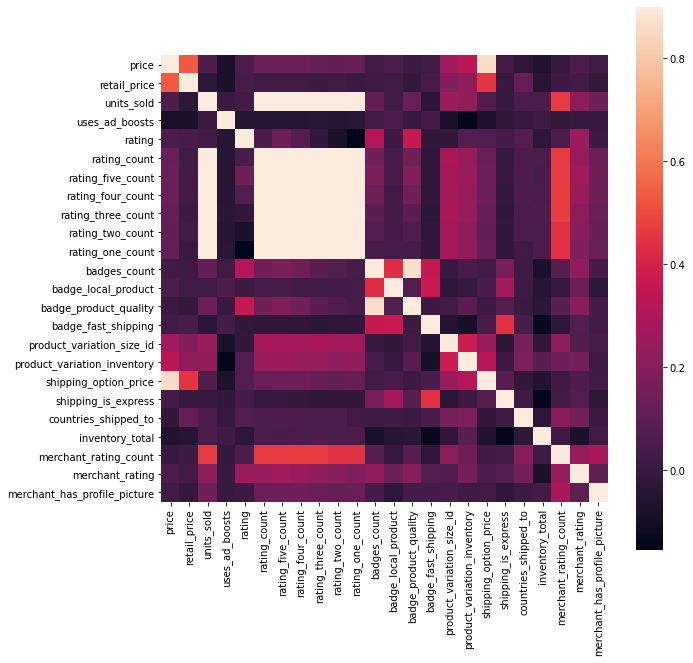

In [8]:
SpearmanCorr = df.corr(method="spearman")
plt.figure(figsize=(10,10))
sns.heatmap(SpearmanCorr, vmax=.9, square=True)

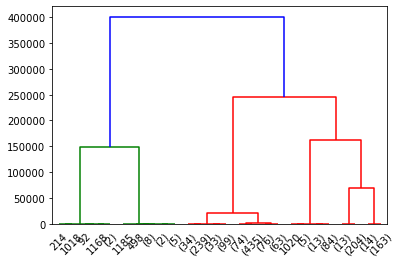

In [9]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
X = df_scale.values
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), truncate_mode='level', p=4)

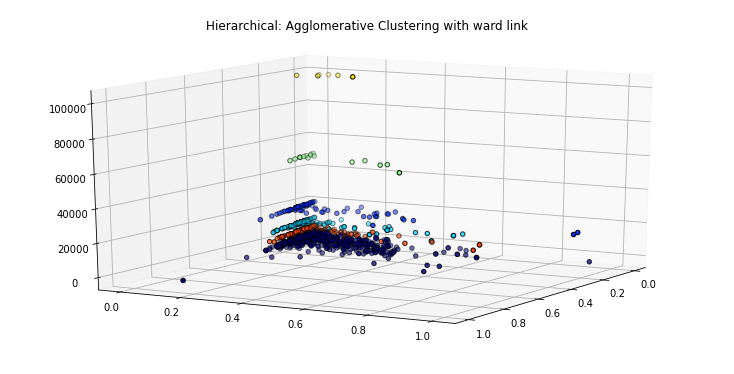

In [10]:
AWcluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
AWcluster.fit(df_scale)
AWlabels = AWcluster.labels_
AWcluster_fit = AWcluster.fit(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(AWlabels):
    ax.scatter(X[AWlabels == l, 0], X[AWlabels == l, 1], X[AWlabels == l, 2],color=plt.cm.jet(float(l) / np.max(AWlabels + 1)),s=20, edgecolor='k')
plt.title('Hierarchical: Agglomerative Clustering with ward link' )

plt.show()

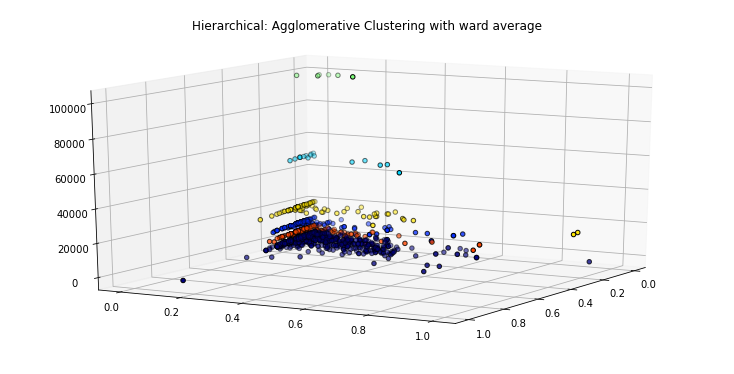

In [11]:
AAcluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')
AAcluster.fit(df_scale)
AAlabels = AAcluster.labels_
AAcluster_fit = AAcluster.fit(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(AAlabels):
    ax.scatter(X[AAlabels == l, 0], X[AAlabels == l, 1], X[AAlabels == l, 2],color=plt.cm.jet(float(l) / np.max(AAlabels + 1)),s=20, edgecolor='k')
plt.title('Hierarchical: Agglomerative Clustering with ward average' )

plt.show()

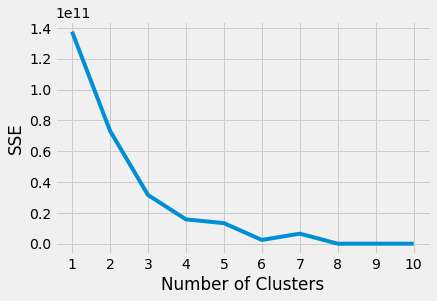

In [12]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(df_scale)
   sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [13]:
KMcluster = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=42)
KMcluster.fit(df_scale)
print('The inertia equals to:' + format(KMcluster.inertia_))
#print('The center of clusters are:' + format(KMcluster.cluster_centers_))

The inertia equals to:15778738836.231256


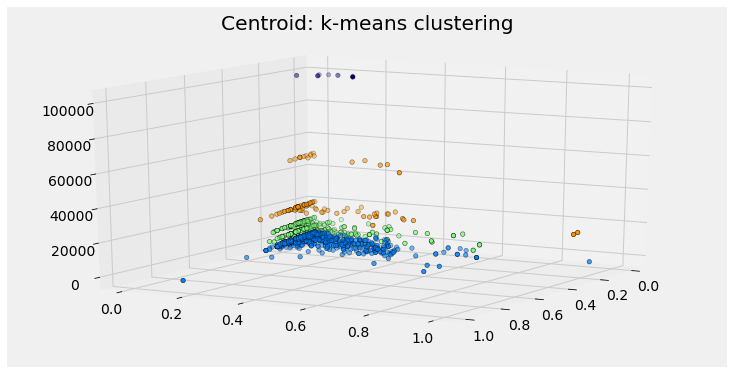

In [14]:
KMcluster_fit = KMcluster.fit(df_scale)
KMlabels = KMcluster.labels_

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(KMlabels):
    ax.scatter(X[KMlabels == l, 0], X[KMlabels == l, 1], X[KMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(KMlabels + 1)),s=20, edgecolor='k')
plt.title('Centroid: k-means clustering' )

plt.show()

In [15]:
DBcluster_fit = DBSCAN(eps=0.3, min_samples=10).fit(df_scale)
core_samples_mask = np.zeros_like(DBcluster_fit.labels_, dtype=bool)
core_samples_mask[DBcluster_fit.core_sample_indices_] = True
DBlabels = DBcluster_fit.labels_ 

In [16]:
DB_n_clusters_ = len(set(DBlabels)) 
DB_n_noise_ = list(DBlabels).count(-1)
print('Estimated number of clusters: %d' % DB_n_clusters_)
print('Estimated number of noise points: %d' % DB_n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 1529


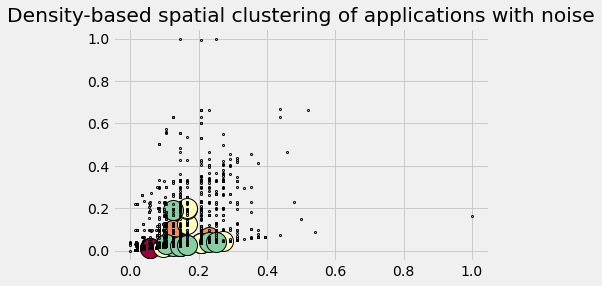

In [17]:
# Black removed and is used for noise instead.
unique_labels = set(DBlabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [1, 0, 0, 0]

    class_member_mask = (DBlabels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=20)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Density-based spatial clustering of applications with noise')
plt.show()

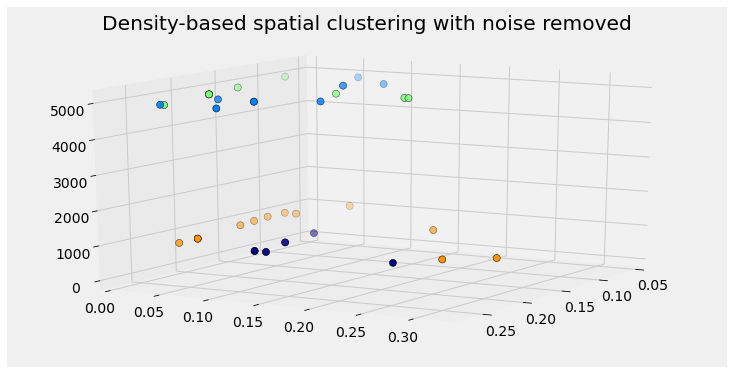

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in range(0,4):
    ax.scatter(X[DBlabels == l, 0], X[DBlabels == l, 1], X[DBlabels == l, 2],color=plt.cm.jet(float(l) / np.max(DBlabels + 1)),s=50, edgecolor='k')
plt.title('Density-based spatial clustering with noise removed' )

plt.show()